# Modelling

### Contents

- [Regression](#1)
	- [Simple Linear Regression](#1)
	- [Boosted Linear Regression](#2)
- [Classification](#3)
	- [Upsampling](#3)
	- [Random Forest](#4)
	- [Multi-Layer Perceptron](#6)
	- [XGBoost](#5)


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from xgboost import XGBClassifier

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score, cross_validate
from sklearn.linear_model import LinearRegression, Lasso, ElasticNet
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import PassiveAggressiveClassifier, SGDClassifier, RidgeClassifier, LogisticRegression
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, roc_auc_score, f1_score, recall_score
from sklearn.utils import resample
from sklearn.neural_network import MLPClassifier

# Bayesian Grid Search 
from hyperopt import tpe,hp,Trials
from hyperopt.fmin import fmin

from NeuralNetwork import NeuralNetwork

In [23]:
df10 = pd.read_csv(('../df10.csv'), index_col=[0])

In [24]:
#Considering records >£100 as outliers, variance can't be explained by the data 
df10 = df10[(df10.pound_value <100)]
df10 = df10.dropna()

#i'll need these at the very end
urls = df10[df10.pound_value<100]['url']
df10 = df10.drop(['url'], axis=1)

y = df10.pop('pound_value')
X = df10

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5,random_state=1)

scaler = StandardScaler()

X_train = pd.DataFrame(scaler.fit_transform(X_train),columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test),columns=X_test.columns)

<a id="1"></a>
### Simple Linear Regression

train score: 0.344
test score: 0.338
Intercept: 9.68


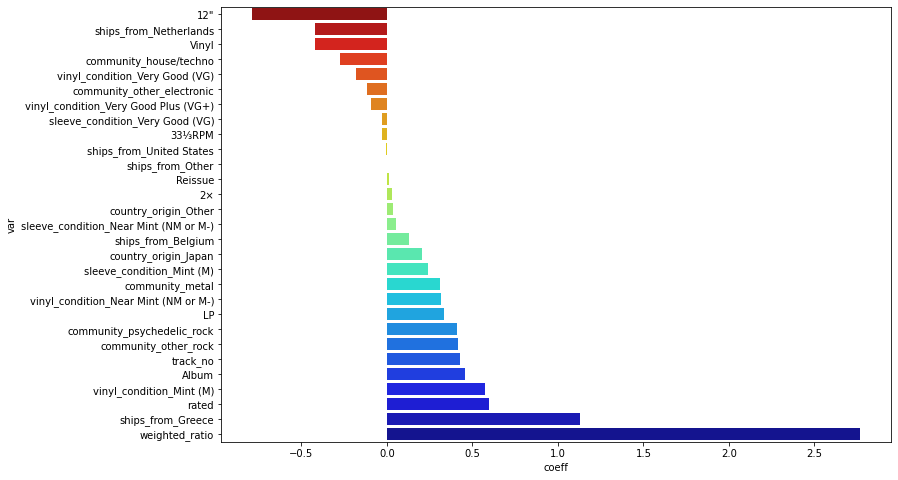

In [25]:
model = ElasticNet()
model.fit(X_train,y_train)

print('train score:',round(model.score(X_train,y_train),3))
print('test score:',round(model.score(X_test,y_test),3))

print('Intercept:',round(model.intercept_,2))
results = pd.DataFrame(list(zip(X_train.columns, model.coef_)),columns=['var', 'coeff'])
results2 = results[results.coeff!=0].sort_values(by='coeff', ascending=True)

plt.figure(figsize=(12,8))
ax = sns.barplot(x='coeff', y='var', data=results2, palette='jet_r')
plt.show()

<a id="2"></a>
## Boosted Regression

In [13]:
#df10['pound_value']=[np.log(x) for x in df10.pound_value]

params = {
          "n_estimators": [100,200,300,400],
          "subsample": [0.5,0.6,0.7,0.8,0.9,1],
          "max_depth":[3,4,5,6,7,8,9,10],
          }

gbr = GradientBoostingRegressor()
gbr_search = RandomizedSearchCV(gbr, 
                                param_distributions=params,
                                cv=3,
                                verbose=0, 
                                n_jobs=-1,
                                n_iter=60)

gbr_search.fit(X_train, y_train, sample_weight=None, monitor=None)

print('train score:',gbr_search.score(X_train, y_train))
print('test score:',gbr_search.score(X_test, y_test))

print(gbr_search.best_params_)

feature_importance = gbr_search.best_estimator_.feature_importances_
variable = X_train.columns

graph = pd.DataFrame({'variable':variable,
                     'feature_importance':feature_importance}).sort_values(by='feature_importance'
                                                                           ,ascending=False).head(25)

plt.figure(figsize=(12,10))
ax = sns.barplot(x='feature_importance', y='variable', data=graph, palette='jet_r')
#plt.xticks(rotation=90)
plt.show()

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3343, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-92fc0578db1a>", line 17, in <module>
    gbr_search.fit(X_train, y_train, sample_weight=None, monitor=None)
  File "/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py", line 72, in inner_f
    return f(**kwargs)
  File "/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py", line 736, in fit
    self._run_search(evaluate_candidates)
  File "/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py", line 1531, in _run_search
    random_state=self.random_state))
  File "/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py", line 715, in evaluate_candidates
    cv.split(X, y, groups)))
  File "/anaconda3/lib/python3.7/site-packages/joblib/parallel.py", line 1042, in __call__
    self.retrieve()
  Fil

TypeError: object of type 'NoneType' has no len()

<a id="3"></a>
## Classification
Framing the problem as multi-class price classification, rather than exact prediction

In [26]:
#recreating final dataset
df10 = pd.read_csv(('../df10.csv'), index_col=[0])
df10 = df10[(df10.pound_value <100)]
df10 = df10.dropna()
df10 = df10.drop(['url'], axis=1)

#turning target into a categorical variable
test = []
for i in df10.pound_value:
    if  i <5:
        test.append('a: £0-5.')
    elif i <10:
        test.append('b: £5-10.')
    elif i <20:
        test.append('c: £10-20.')
    elif i <30:
        test.append('d: £20-30.')
    elif i <40:
        test.append('e: £30-40.')
    elif i <50:
        test.append('f: £40-50.')
    elif i <60:
        test.append('g: £50-60.')
    elif i <70:
        test.append('h: £60-70.')
    elif i <100:
        test.append('i: £70-100.')
    else:
        test.append('j: £100-1000000.')
        
df10['pound_value'] = test

print(df10['pound_value'].value_counts())

a: £0-5.       12527
b: £5-10.      10985
c: £10-20.      6232
d: £20-30.      1674
e: £30-40.       757
f: £40-50.       434
i: £70-100.      205
g: £50-60.       196
h: £60-70.       129
Name: pound_value, dtype: int64


## Baseline

In [15]:
print('baseline:',round(len(df10[df10.pound_value=='a: £0-5.'])/len(df10),4))

baseline: 0.378


## Upsampling

In [44]:
#shuffling
df10 = df10.sample(frac=1).reset_index(drop=True)

#50% train test split
SplitSize = int(len(df10)/2)
train = df10[SplitSize:]
test = df10[:SplitSize]

def upsample(df, baseClass, imbalancedClass):
    base = df[df.pound_value == baseClass]
    imbalanced = df[df.pound_value == imbalancedClass]
    upsampled = resample(imbalanced, replace=True, n_samples=len(base), random_state=123)
    return upsampled

classes = df10['pound_value'].unique()

upsampledDfs = []
for i in classes:
    upsampleData = upsample(train, 'a: £0-5.', i)
    upsampledDfs.append(upsampleData)
    
train = pd.concat(upsampledDfs) 

X_train = train.loc[:, data.columns != 'pound_value']
y_train = train['pound_value']
X_test = test.loc[:, data.columns != 'pound_value']
y_test = test['pound_value']

# scaler = StandardScaler()
# X_train = pd.DataFrame(scaler.fit_transform(X_train),columns=X_train.columns)
# X_test = pd.DataFrame(scaler.transform(X_test),columns=X_test.columns)
   
print(y_train.pound_value.value_counts())

d: £20-30.     12527
f: £40-50.     12527
g: £50-60.     12527
e: £30-40.     12527
a: £0-5.       12527
c: £10-20.     12527
b: £5-10.      12527
i: £70-100.    12527
h: £60-70.     12527
Name: pound_value, dtype: int64


<a id="4"></a>
## Random Forest - with Bayesian Parameter Optimisation

In [ ]:
seed = 2
max_trials = 200

def objective(params):
    n_estimators = int(params['n_estimators'])
    max_depth = int(params['max_depth'])
    min_samples_leaf = int(params['min_samples_leaf'])
    min_samples_split = int(params['min_samples_split'])
    rf = RandomForestClassifier(n_jobs=-1,
                                  n_estimators=n_estimators,
                                  max_depth=max_depth,
                                  min_samples_leaf=min_samples_leaf,
                                  min_samples_split=min_samples_split
                                 )
    rf.fit(X_train, y_train)
    pred_y = rf.predict(X_train)
    cv = cross_validate(rf, X_train, y_train, scoring='accuracy', cv=4)
    score = np.average(cv['test_score'])
    return score

def optimize(trial):
    params={
           'n_estimators':hp.uniform('n_estimators',50,200),
           'max_depth':hp.uniform('max_depth',10,40),
           'min_samples_leaf':hp.uniform('min_samples_leaf',1,20),
           'min_samples_split':hp.uniform('min_samples_split',2,20)
           }
    
    best = fmin(fn=objective,
                space=params,
                algo=tpe.suggest,
                trials=trial,
                max_evals=max_trials,
                rstate=np.random.RandomState(seed))
    return best

trial = Trials()
best = optimize(trial)
best

In [45]:
rf = RandomForestClassifier(max_depth=11,
                            n_estimators=91, 
                            min_samples_leaf=20,
                            min_samples_split=8).fit(X_train, y_train)
pred_y = rf.predict(X_test)
print('accuracy:', round(accuracy_score(y_test, pred_y),3))
# # print('recall:', round(recall_score(y_test, pred_y),3))
# print('f1:', round(f1_score(y_test, pred_y),3))
# print('')
print(classification_report(y_test, pred_y))

accuracy: 0.536
              precision    recall  f1-score   support

    a: £0-5.       0.73      0.70      0.71      6259
   b: £5-10.       0.60      0.52      0.55      5492
  c: £10-20.       0.42      0.41      0.42      3103
  d: £20-30.       0.21      0.23      0.22       847
  e: £30-40.       0.13      0.21      0.16       396
  f: £40-50.       0.08      0.18      0.11       197
  g: £50-60.       0.04      0.08      0.05       100
  h: £60-70.       0.08      0.24      0.12        67
 i: £70-100.       0.09      0.24      0.13       108

    accuracy                           0.54     16569
   macro avg       0.26      0.31      0.28     16569
weighted avg       0.57      0.54      0.55     16569



<a id="6"></a>
## Multi-Layer Perceptron

In [48]:
MLP = MLPClassifier(hidden_layer_sizes=(100, 150, 150, 75))
MLP.fit(X_train, y_train)
pred_y = MLP.predict(X_test)
print('accuracy:', round(accuracy_score(y_test, pred_y),3))
print(classification_report(y_test, pred_y))

accuracy: 0.535
              precision    recall  f1-score   support

    a: £0-5.       0.72      0.66      0.69      6259
   b: £5-10.       0.53      0.57      0.55      5492
  c: £10-20.       0.42      0.42      0.42      3103
  d: £20-30.       0.21      0.22      0.21       847
  e: £30-40.       0.16      0.16      0.16       396
  f: £40-50.       0.14      0.21      0.17       197
  g: £50-60.       0.06      0.05      0.05       100
  h: £60-70.       0.09      0.10      0.09        67
 i: £70-100.       0.12      0.16      0.13       108

    accuracy                           0.53     16569
   macro avg       0.27      0.28      0.28     16569
weighted avg       0.55      0.53      0.54     16569



<a id="5"></a>
## XGBoost - with Bayesian Parameter Optimisation

In [94]:
seed = 2
max_trials = 10

def objective(params):
    n_estimators = int(params['n_estimators'])
    max_depth = int(params['max_depth'])
    learning_rate = params['learning_rate']
    gamma = params['gamma']
    
    XGB = XGBClassifier(n_jobs=0,
                        n_estimators=n_estimators,
                        max_depth=max_depth,
                        learning_rate=learning_rate,
                        gamma=gamma,
                       )
    
    eval_set = [(X_test, y_test)]
    
    XGB.fit(X_train, y_train, early_stopping_rounds=5,
            eval_metric="mlogloss", eval_set=eval_set, verbose=False)
    
    pred_y = rf.predict(X_train)
    cv = cross_validate(XGB, X_train, y_train, scoring='accuracy', cv=3)
    score = np.average(cv['test_score'])
    return score

def optimize(trial):
    params={
           'n_estimators' : hp.choice('n_estimators', range(20, 205, 5)),
           'max_depth':hp.uniform('max_depth',10,40),
           'learning_rate' : hp.quniform('learning_rate', 0.01, 0.5, 0.01),
           'gamma' : hp.quniform('gamma', 0, 0.50, 0.01),
           }
    
    best = fmin(fn=objective,
                space=params,
                algo=tpe.suggest,
                trials=trial,
                max_evals=max_trials,
                rstate=np.random.RandomState(seed))
    return best

trial = Trials()
best = optimize(trial)
best

100%|██████████| 10/10 [1:34:06<00:00, 564.67s/trial, best loss: 0.5953286257468767]


{'gamma': 0.3,
 'learning_rate': 0.39,
 'max_depth': 17.42905285316997,
 'n_estimators': 16}

In [47]:
eval_set = [(X_test, y_test)]

XGB = XGBClassifier(n_jobs=0,
                    n_estimators=int(best['n_estimators']),
                    max_depth=int(best['max_depth']),
                    learning_rate=best['learning_rate'],
                    gamma=best['gamma'],
                   )


XGB.fit(X_train, y_train, early_stopping_rounds=5, 
        eval_metric="mlogloss", 
        eval_set=eval_set, verbose=False)

pred_y = XGB.predict(X_test)
print('accuracy:', round(accuracy_score(y_test, pred_y),3))
print(classification_report(y_test, pred_y))

accuracy: 0.569
              precision    recall  f1-score   support

    a: £0-5.       0.73      0.72      0.73      6259
   b: £5-10.       0.57      0.55      0.56      5492
  c: £10-20.       0.45      0.52      0.48      3103
  d: £20-30.       0.23      0.22      0.23       847
  e: £30-40.       0.18      0.15      0.16       396
  f: £40-50.       0.18      0.19      0.18       197
  g: £50-60.       0.06      0.05      0.06       100
  h: £60-70.       0.15      0.15      0.15        67
 i: £70-100.       0.16      0.16      0.16       108

    accuracy                           0.57     16569
   macro avg       0.30      0.30      0.30     16569
weighted avg       0.57      0.57      0.57     16569

